В этом задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации


### Что нужно сделать? 

1. Подготовка :
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. (+)
    - Придумайте и обоснуйте стратегию валидации. (+)
    - Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.(+)
2. Примените любой Embedding (word2vec или Glove) (+)
3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):
    - Одномерные свертки (+)
    - LSTM или GRU (+)
    - Bidirectional LSTM    (+)
4. Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. 


In [3]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Embedding, Activation, GlobalMaxPooling1D
from keras.layers import LSTM, Bidirectional, GRU
from keras.models import Model, Sequential
from keras.callbacks import Callback
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
import re
import codecs
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## EDA

In [5]:
df = pd.read_csv("train.csv")

### Посмотрим частоту появления каждого из классов

In [6]:
col_names = df.columns.values[2:]
col_names = col_names.tolist()
col_names.append('None')
x = [sum(df[y]) for y in df.columns.values[2:]]
x.append(len(df) - sum(x))

In [7]:
X = []
for i in range(len(x)-1):
    X.append(x[i])

Text(0, 0.5, 'Frequency')

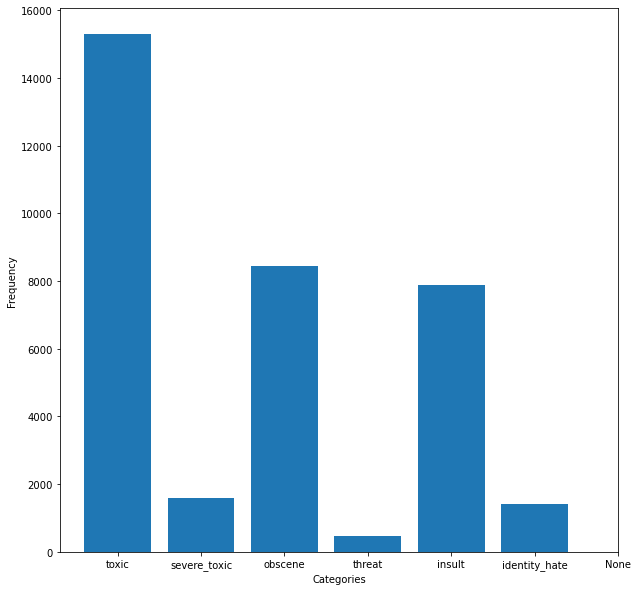

In [8]:
plt.figure(figsize = (10, 10))
plt.bar(np.arange(len(X)), X)
plt.xticks(np.arange(7), col_names)
plt.xlabel('Categories')
plt.ylabel('Frequency')

Можно сделать вывод, что классы не сбалансированы.

### Посмотрим на пересечения двух разных классов

In [9]:
df.corr().unstack().sort_values(ascending=False)[0:20:2]

identity_hate  identity_hate    1.000000
severe_toxic   severe_toxic     1.000000
threat         threat           1.000000
insult         obscene          0.741272
toxic          obscene          0.676515
insult         toxic            0.647518
obscene        severe_toxic     0.403014
insult         severe_toxic     0.375807
               identity_hate    0.337736
toxic          severe_toxic     0.308619
dtype: float64

Видим, что классы пересекаются. Например, insult и obscene пересекаются в 74% случаев.

## Подготовка текста
Уберем слова из набора contraction_mapping, они не влияют на "токсичность" комментариев. Приведем все слова к нижнему регистру, уберем знаки препинания, символы.

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [11]:
def text_cleaner(text,num):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split()]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [12]:
cleaned_text = []
for t in train['comment_text']:
    cleaned_text.append(text_cleaner(t,0))

In [13]:
train['comment_text'] = cleaned_text

In [14]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww he matches this background colour am seemi...,0,0,0,0,0,0
2,000113f07ec002fd,hey man am really not trying to edit war it is...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more cannot make any real suggestions on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


## Лемматизация
Выбираю лемматизацию, так как здесь слова приводятся к начальной форме, а в стемминге обрезаются концы слов.

In [19]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Зина\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Зина\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [20]:
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
lemmatizer = WordNetLemmatizer()
word_list = []

for i in range(train.shape[0]):
    word_list.append(word_tokenize(train["comment_text"][i]))
    
lem_out = []

for j in range(len(word_list)):
    lem_out.append(' '.join([lemmatizer.lemmatize(w) for w in word_list[j]]))

In [21]:
train["comment_text"] = lem_out

In [22]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww he match this background colour am seeming...,0,0,0,0,0,0
2,000113f07ec002fd,hey man am really not trying to edit war it is...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more can not make any real suggestion on impro...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


## Embedding

In [23]:
embed_size = 50
max_features = 20000  
maxlen = 100 


list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values

# Превращаем каждый комментарий в список индексов слов одинаковой длины (с усечением или дополнением по мере необходимости).
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train)) # учимся на тренировочном тесте
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train) # Переводим тексты трэйна и теста в последовательности
x_train = pad_sequences(list_tokenized_train, maxlen=maxlen) # Делаем длину векторов одинаковой

In [24]:
EMBEDDING_FILE = 'glove.6B.50d.txt'

def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in codecs.open(EMBEDDING_FILE, "r", "utf_8_sig" ))

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std() 
emb_mean, emb_std

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(0.020940498, 0.6441043)

In [25]:
word_index = tokenizer.word_index 
nb_words = min(max_features, len(word_index)) 
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(20000, 50)

In [27]:
class RocAucEvaluation(Callback):
    def __init__(self, training_data, validation_data, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_train, self.y_train = training_data
        self.X_val, self.y_val = validation_data
        self.score_train = []
        self.score_val = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred_val = self.model.predict(self.X_val, verbose=0)
            y_pred_train = self.model.predict(self.X_train, verbose=0)
            score_train = roc_auc_score(self.y_train, y_pred_train) 
            score_val = roc_auc_score(self.y_val, y_pred_val)
            self.score_train.append(score_train)
            self.score_val.append(score_val)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score_val))

## Разбиение на train и validation
Хотелось бы тренироваться на максимально возможном количестве данных, поэтому train_size=0.9
Посмотрела некоторые варианты решения на каггл, берут 0.95, но, по-моему, это многовато.

In [28]:
X_tr, X_val, y_tr, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=42)
RocAuc = RocAucEvaluation(training_data=(X_tr, y_tr), validation_data=(X_val, y_val), interval=1)


# Пора учить модели!

Использую самые простые архитектуры, это позволит относительно быстро обучиться и сравнить их. Также обучаюсь на пяти эпохах, потому что по train сетка переобучается, а по val перестает сильно расти (это очень хорошо видно в GRU).

## Одномерные свертки

In [29]:
cnn_model = Sequential()
#cnn_model.add(Input(shape=(maxlen, )))
cnn_model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
cnn_model.add(Conv1D(128,3,
                padding='valid',
                 activation='relu',
                 strides=1))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(6))
cnn_model.add(Activation('sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         19328     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
activation (Activation)      (None, 6)                 0         
Total params: 1,020,102
Trainable params: 20,102
Non-trainable params: 1,000,000
_________________________________________________________________


In [30]:
cnn_hist = cnn_model.fit(X_tr, y_tr, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[RocAuc])

Epoch 1/5
4488/4488 [==============================] - 22s 5ms/step - loss: 0.0804 - accuracy: 0.7886 - val_loss: 0.0551 - val_accuracy: 0.8846

 ROC-AUC - epoch: 1 - score: 0.975633 

Epoch 2/5
4488/4488 [==============================] - 21s 5ms/step - loss: 0.0558 - accuracy: 0.8099 - val_loss: 0.0526 - val_accuracy: 0.8607

 ROC-AUC - epoch: 2 - score: 0.977563 

Epoch 3/5
4488/4488 [==============================] - 21s 5ms/step - loss: 0.0511 - accuracy: 0.8165 - val_loss: 0.0531 - val_accuracy: 0.7859

 ROC-AUC - epoch: 3 - score: 0.977842 

Epoch 4/5
4488/4488 [==============================] - 21s 5ms/step - loss: 0.0490 - accuracy: 0.7790 - val_loss: 0.0537 - val_accuracy: 0.9546

 ROC-AUC - epoch: 4 - score: 0.978185 

Epoch 5/5
4488/4488 [==============================] - 21s 5ms/step - loss: 0.0469 - accuracy: 0.7947 - val_loss: 0.0529 - val_accuracy: 0.8947

 ROC-AUC - epoch: 5 - score: 0.977709 



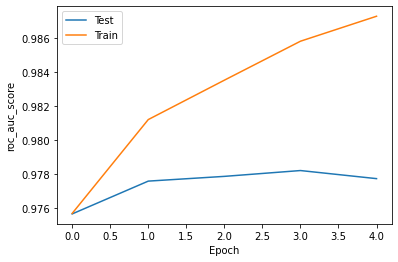

In [31]:
plt.plot(RocAuc.score_val, label='Test')
plt.plot(RocAuc.score_train, label='Train')
plt.xlabel('Epoch')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

## LSTM или GRU
Решила посмотреть обе модели

#### GRU

In [32]:
gru_model = Sequential()
gru_model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(128))#return_sequences=True))
gru_model.add(Dense(6, activation='sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
gru (GRU)                    (None, 128)               69120     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 1,069,894
Trainable params: 69,894
Non-trainable params: 1,000,000
_________________________________________________________________


In [33]:
gru_hist = gru_model.fit(X_tr, y_tr, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[RocAuc])

Epoch 1/5
4488/4488 [==============================] - 147s 32ms/step - loss: 0.0799 - accuracy: 0.9581 - val_loss: 0.0557 - val_accuracy: 0.9775

 ROC-AUC - epoch: 1 - score: 0.975445 

Epoch 2/5
4488/4488 [==============================] - 142s 32ms/step - loss: 0.0539 - accuracy: 0.9667 - val_loss: 0.0504 - val_accuracy: 0.7543

 ROC-AUC - epoch: 2 - score: 0.981748 

Epoch 3/5
4488/4488 [==============================] - 143s 32ms/step - loss: 0.0492 - accuracy: 0.9385 - val_loss: 0.0470 - val_accuracy: 0.8907

 ROC-AUC - epoch: 3 - score: 0.983523 

Epoch 4/5
4488/4488 [==============================] - 145s 32ms/step - loss: 0.0472 - accuracy: 0.9140 - val_loss: 0.0467 - val_accuracy: 0.9518

 ROC-AUC - epoch: 4 - score: 0.984003 

Epoch 5/5
4488/4488 [==============================] - 147s 33ms/step - loss: 0.0450 - accuracy: 0.9458 - val_loss: 0.0468 - val_accuracy: 0.9509

 ROC-AUC - epoch: 5 - score: 0.983601 



In [34]:
gru_val = []
for i in range(5):
    gru_val.append(RocAuc.score_val[i+5])
    
gru_train = []
for i in range(5):
    gru_train.append(RocAuc.score_train[i+5])

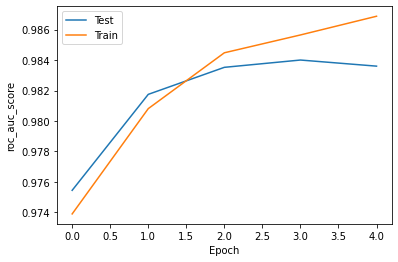

In [35]:
plt.plot(gru_val, label='Test')
plt.plot(gru_train, label='Train')
plt.xlabel('Epoch')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

#### LSTM

In [36]:
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(128))#return_sequences=True))
lstm_model.add(Dense(6, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 1,092,422
Trainable params: 92,422
Non-trainable params: 1,000,000
_________________________________________________________________


In [37]:
lstm_hist = lstm_model.fit(X_tr, y_tr, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[RocAuc])

Epoch 1/5
4488/4488 [==============================] - 180s 40ms/step - loss: 0.0896 - accuracy: 0.9382 - val_loss: 0.0592 - val_accuracy: 0.9930

 ROC-AUC - epoch: 1 - score: 0.969183 

Epoch 2/5
4488/4488 [==============================] - 177s 39ms/step - loss: 0.0584 - accuracy: 0.9931 - val_loss: 0.0515 - val_accuracy: 0.9937

 ROC-AUC - epoch: 2 - score: 0.975562 

Epoch 3/5
4488/4488 [==============================] - 175s 39ms/step - loss: 0.0525 - accuracy: 0.9911 - val_loss: 0.0492 - val_accuracy: 0.9856

 ROC-AUC - epoch: 3 - score: 0.979743 

Epoch 4/5
4488/4488 [==============================] - 165s 37ms/step - loss: 0.0495 - accuracy: 0.9847 - val_loss: 0.0484 - val_accuracy: 0.9916

 ROC-AUC - epoch: 4 - score: 0.980070 

Epoch 5/5
4488/4488 [==============================] - 179s 40ms/step - loss: 0.0457 - accuracy: 0.9889 - val_loss: 0.0471 - val_accuracy: 0.9797

 ROC-AUC - epoch: 5 - score: 0.980982 



In [42]:
lstm_val = []
for i in range(5):
    lstm_val.append(RocAuc.score_val[i+10])
    
lstm_train = []
for i in range(5):
    lstm_train.append(RocAuc.score_train[i+10])

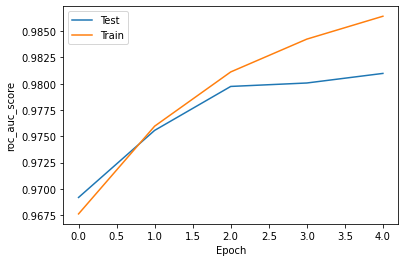

In [43]:
plt.plot(lstm_val, label='Test')
plt.plot(lstm_train, label='Train')
plt.xlabel('Epoch')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

## Bidirectional LSTM

In [40]:
blstm_model = Sequential()
blstm_model.add(Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False))
blstm_model.add(Bidirectional(LSTM(128)))
blstm_model.add(Dense(6, activation='sigmoid'))
blstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
blstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 1,184,838
Trainable params: 184,838
Non-trainable params: 1,000,000
_________________________________________________________________


In [41]:
blstm_hist = blstm_model.fit(X_tr, y_tr, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[RocAuc])

Epoch 1/5
4488/4488 [==============================] - 250s 55ms/step - loss: 0.0842 - accuracy: 0.9665 - val_loss: 0.0565 - val_accuracy: 0.9940

 ROC-AUC - epoch: 1 - score: 0.972996 

Epoch 2/5
4488/4488 [==============================] - 261s 58ms/step - loss: 0.0551 - accuracy: 0.9890 - val_loss: 0.0517 - val_accuracy: 0.9922

 ROC-AUC - epoch: 2 - score: 0.977051 

Epoch 3/5
4488/4488 [==============================] - 263s 59ms/step - loss: 0.0504 - accuracy: 0.9849 - val_loss: 0.0483 - val_accuracy: 0.9867

 ROC-AUC - epoch: 3 - score: 0.981292 

Epoch 4/5
4488/4488 [==============================] - 248s 55ms/step - loss: 0.0465 - accuracy: 0.9760 - val_loss: 0.0485 - val_accuracy: 0.9882

 ROC-AUC - epoch: 4 - score: 0.981199 

Epoch 5/5
4488/4488 [==============================] - 269s 60ms/step - loss: 0.0438 - accuracy: 0.9816 - val_loss: 0.0469 - val_accuracy: 0.9862

 ROC-AUC - epoch: 5 - score: 0.980529 



In [44]:
blstm_val = []
for i in range(5):
    blstm_val.append(RocAuc.score_val[i+15])
    
blstm_train = []
for i in range(5):
    blstm_train.append(RocAuc.score_train[i+15])

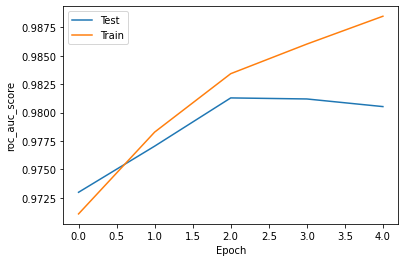

In [45]:
plt.plot(blstm_val, label='Test')
plt.plot(blstm_train, label='Train')
plt.xlabel('Epoch')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

### Построим графики roc_auc_score для каждой модели на валидации и сравним их

In [46]:
cnn_val = []
for i in range(5):
    cnn_val.append(RocAuc.score_val[i])

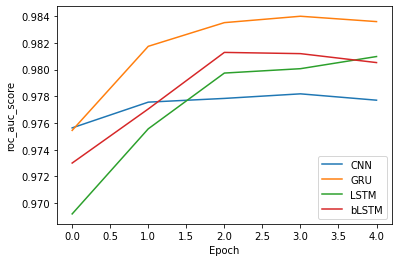

In [47]:
plt.plot(cnn_val, label='CNN')
plt.plot(gru_val, label='GRU')
plt.plot(lstm_val, label='LSTM')
plt.plot(blstm_val, label='bLSTM')
plt.xlabel('Epoch')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

GRU выдает лучший результат!